<h1 style="font-size:2.75rem;color:black;"> Design Script for a Differential Pair with Active Loads</h1>

# <u> Imports

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter

# <u> Units

In [2]:
q  = 1.60e-19   # Electron charge
KB = 1.38e-23   # Boltzmann constant

engFormat_Gain  = EngFormatter(unit='dB',     places=3, sep=' ')
engFormat_GBW   = EngFormatter(unit='Hz',     places=3, sep=' ')
engFormat_OS    = EngFormatter(unit='V',      places=3, sep=' ')
engFormat_PD    = EngFormatter(unit='W',      places=3, sep=' ')
engFormat_FoM   = EngFormatter(unit='s/V^-2', places=3, sep=' ')
engFormat_Width = EngFormatter(unit='m',      places=2, sep=' ')

# <u> Design data

In [3]:
IB  = 100e-06   # Bias current
CL  = 2.0e-12   # Load capacitance
VDD = 1.2       # Supply voltage
BE  = 0.75

# Transistor lengths
L_1P     = 0.6e-06;  L_3P    = 0.6e-06;  L_5N     =   0.6e-06; L_7aN =   0.6e-06; L_7bN =   0.6e-06; L_9P =    0.6e-06; L_10P = 0.6e-06; L_13N = 0.6e-06;
# Bulk-source voltage drop
VBS_1P  = 300e-03;  VBS_3P   = 300e-03;  VBS_5N   = 300e-03; VBS_7aN   = 0; VBS_7aN   = 0; VBS_9P   = 0; VBS_10P   = 0; VBS_13N   = 300e-03;
VDB_1P  = 300e-03;  VDB_3P   = 300e-03;  VDB_5N   =300e-03 ; VDB_7aN   = 0; VDB_7bN   = 0; VDB_9P   = 0; VDB_10P   = 0; VDB_13N   = 300e-03;
# Saturation voltage voltage
VDSAT_1P = 100e-03;  VDSAT_3P = 100e-03;  VDSAT_5N = 100e-03;  VDSAT_7aN = 100e-03; VDSAT_7bN = 100e-03; VDSAT_9P = 100e-03; VDSAT_10P = 100e-03; VDSAT_13N = 100e-03;

# Array definition
L_arr    = np.arange(0.24e-06, 1.00e-06, 0.76e-06/100)
VSAT_arr = np.arange(50e-03, 250e-03, 200e-03/100)

# <u> Technology Definitions

In [4]:
# Parameters for TSMC65NM (K = u0*Cox = u0*E0*epsrox/toxm)
V_TN = 0.28615208;   K_N = 244.961e-06; # 0.0184444380*8.854e-12*3.9/2.60e-09
V_TP = 0.43718619;   K_P = 130.808e-06; # 0.0106069150*8.854e-12*3.9/2.80e-09

# Non LDD region source-gate overlap capacitance per unit channel width - CGSO/CGDO (TSMC65NM)
CGSD0_N = 89.18e-12
CGSD0_P = 74.90e-12

# Cox = E0*Er/tox (TSMC65NM)
COX_N = 13.28e-03   # 8.854e-12*3.9/2.60e-09
COX_P = 12.33e-03   # 8.854e-12*3.9/2.80e-09

# Drain/source minimum drawing area
Sd_s = 0.2*1e-06

# Bottom junction capacitance per unit area at zero bias - CJS/CJD (TSMC65NM)
CJ_N   = 1.185e-03;   CJ_P   = 1.068e-03;

# Bottom junction built-in potential - PBS/PBD (TSMC65NM)
PB_N   = 0.700;       PB_P   = 0.700;

# Bottom junction capacitance grating coefficient - MJS/MJD (TSMC65NM)
MJ_N   = 0.310;       MJ_P   = 0.310;

# Isolation-edge sidewall junction capacitance per unit area - CJSWS/CJSWD (TSMC65NM)
CJSW_N = 94.00e-12;   CJSW_P =  76.00e-12;

# Isolation-edge sidewall junction capacitance grading coefficient MJSWS/MJSWD (TSMC65NM)
MJSW_N = 0.080;       MJSW_P = 0.060;

In [5]:
# u0 is dependent on the transistor dimensions
def u0_arr_N(W, L):
    if   (W >=  10e-06 and W <= 900e-06):
        if   (L >=  10e-06 and L <=  20e-06): return 0.0203900000
        elif (L >=   1e-06 and L <   10e-06): return 0.0206752440
        elif (L >= 240e-09 and L <    1e-06): return 0.0184444380
        elif (L >= 100e-09 and L <  240e-09): return 0.0159778710
        elif (L >=  60e-09 and L <  100e-09): return 0.0105131640
        else: return -1
    elif (W >=   1e-06 and W <   10e-06):
        if   (L >=  10e-06 and L <=  20e-06): return 0.0205407330
        elif (L >=   1e-06 and L <   10e-06): return 0.0208280430
        elif (L >= 240e-09 and L <    1e-06): return 0.0185811630
        elif (L >= 100e-09 and L <  240e-09): return 0.0160011950
        elif (L >=  60e-09 and L <  100e-09): return 0.0106698390
        else: return -1
    elif (W >= 600e-09 and W <    1e-06):
        if   (L >=  10e-06 and L <=  20e-06): return 0.0217105000
        elif (L >=   1e-06 and L <   10e-06): return 0.0220157430
        elif (L >= 240e-09 and L <    1e-06): return 0.0196231290
        elif (L >= 100e-09 and L <  240e-09): return 0.0179624840
        elif (L >=  60e-09 and L <  100e-09): return 0.0082323123
        else: return -1
    elif (W >= 300e-09 and W <  600e-06):
        if   (L >=  10e-06 and L <=  20e-06): return 0.0174033330
        elif (L >=   1e-06 and L <   10e-06): return 0.0176456830
        elif (L >= 240e-09 and L <    1e-06): return 0.0157559150
        elif (L >= 100e-09 and L <  240e-09): return 0.0144015760
        elif (L >=  60e-09 and L <  100e-09): return 0.0066402542
        else: return -1
    elif (W >= 120e-09 and W <  300e-06):
        if   (L >=  10e-06 and L <=  20e-06): return 0.0175100000
        elif (L >=   1e-06 and L <   10e-06): return 0.0177556860
        elif (L >= 240e-09 and L <    1e-06): return 0.0158322950
        elif (L >= 100e-09 and L <  240e-09): return 0.0147731200
        elif (L >=  60e-09 and L <  100e-09): return 0.0128307880
        else: return -1
    else:
        return -1

def u0_arr_P(W, L):
    if   (W >=  10e-06 and W <= 900e-06):
        if   (L >=  10e-06 and L <=  20e-06): return 0.0117200000
        elif (L >=   1e-06 and L <   10e-06): return 0.0118838970
        elif (L >= 240e-09 and L <    1e-06): return 0.0106069150
        elif (L >= 100e-09 and L <  240e-09): return 0.0097253089
        elif (L >=  60e-09 and L <  100e-09): return 0.0054866509
        else: return -1
    elif (W >=   1e-06 and W <   10e-06):
        if   (L >=  10e-06 and L <=  20e-06): return 0.0116905330
        elif (L >=   1e-06 and L <   10e-06): return 0.0118730050
        elif (L >= 240e-09 and L <    1e-06): return 0.0103958770
        elif (L >= 100e-09 and L <  240e-09): return 0.0095315421
        elif (L >=  60e-09 and L <  100e-09): return 0.0053767740
        else: return -1
    elif (W >= 600e-09 and W <    1e-06):
        if   (L >=  10e-06 and L <=  20e-06): return 0.0115615000
        elif (L >=   1e-06 and L <   10e-06): return 0.0113074600
        elif (L >= 240e-09 and L <    1e-06): return 0.0145007250
        elif (L >= 100e-09 and L <  240e-09): return 0.0132993490
        elif (L >=  60e-09 and L <  100e-09): return 0.0076226273
        else: return -1
    elif (W >= 300e-09 and W <  600e-06):
        if   (L >=  10e-06 and L <=  20e-06): return 0.0135300000
        elif (L >=   1e-06 and L <   10e-06): return 0.0137039520
        elif (L >= 240e-09 and L <    1e-06): return 0.0123928480
        elif (L >= 100e-09 and L <  240e-09): return 0.0113642910
        elif (L >=  60e-09 and L <  100e-09): return 0.0055557057
        else: return -1
    elif (W >= 120e-09 and W <  300e-06):
        if   (L >=  10e-06 and L <=  20e-06): return 0.0104900000
        elif (L >=   1e-06 and L <   10e-06): return 0.0106371380
        elif (L >= 240e-09 and L <    1e-06): return 0.0094906926
        elif (L >= 100e-09 and L <  240e-09): return 0.0086965429
        elif (L >=  60e-09 and L <  100e-09): return 0.0048266510
        else: return -1
    else:
        return -1

def u0_arr_N_cond(W, L):
    return np.vectorize(u0_arr_N)(W, L)

def u0_arr_P_cond(W, L):
    return np.vectorize(u0_arr_P)(W, L)

# <u> Transistor equations

In [6]:
def gm(ID, VDSAT):
    return np.piecewise (VDSAT, [VDSAT < 2*KB*300/q, VDSAT >= 2*KB*300/q], \
                  [lambda VDSAT: ID/(KB*300/q), lambda VDSAT: 2*ID/VDSAT])

# NEW EQUATION - CALCULATES W A SECOND TIME TO MAKE SURE IT USES THE CORRECT u0 VALUE
def W_N(ID, VDSAT, L):
    W_est = L * 2 * ID / (K_N * VDSAT**2)
    for i in range(0, 1):
        W_est = L * 2 * ID / (u0_arr_N_cond(W_est, L) * COX_N * VDSAT**2)
    return W_est

def W_P(ID, VDSAT, L):
    W_est = L * 2 * ID / (K_P * VDSAT**2)
    for i in range(0, 1):
        W_est = L * 2 * ID / (u0_arr_P_cond(W_est, L) * COX_N * VDSAT**2)
    return W_est

def gds_N(ID, L):
    return ID / (5000 * L * 1e-03/1e-06)

def gds_P(ID, L):
    return ID / (7500 * L * 1e-03/1e-06)

def CGD_N(ID, VDSAT, L):
    return W_N(ID, VDSAT, L) * CGSD0_N

def CGD_P(ID, VDSAT, L):
    return W_P(ID, VDSAT, L) * CGSD0_P

def CGS_N(ID, VDSAT, L):
    return (2/3) * W_N(ID, VDSAT, L) * L * COX_N

def CGS_P(ID, VDSAT, L):
    return (2/3) * W_P(ID, VDSAT, L) * L * COX_P

def CDB_N(ID, VDSAT, L, VDB):
    return ((W_N(ID, VDSAT, L) + Sd_s) * 2 * CJSW_N) / ((1 + VDB / PB_N)**MJSW_N) + \
        (W_N(ID, VDSAT, L) * Sd_s * CJ_N) / ((1 + VDB / PB_N)**MJ_N)

def CDB_P(ID, VDSAT, L, VDB):
    return ((W_P(ID, VDSAT, L) + Sd_s) * 2 * CJSW_P) / ((1 + VDB / PB_P)**MJSW_P) + \
        (W_P(ID, VDSAT, L) * Sd_s * CJ_P) / ((1 + VDB / PB_P)**MJ_P)

def CSB_N(ID, VDSAT, L, VBS):
    return ((W_N(ID, VDSAT, L) * (Sd_s + L) * CJ_N) / ((1 - VBS / PB_N)**MJ_N)) + \
        ((W_N(ID, VDSAT, L) + Sd_s) * 2 * CJSW_N) / ((1 - VBS / PB_N)**MJSW_N) + \
        (2 * W_N(ID, VDSAT, L) * L * CJ_N) / (3 * ((1 - VBS / PB_N)**MJ_N))

def CSB_P(ID, VDSAT, L, VBS):
    return ((W_P(ID, VDSAT, L) * (Sd_s + L) * CJ_P) / ((1 - VBS / PB_P)**MJ_P)) + \
        ((W_P(ID, VDSAT, L) + Sd_s) * 2 * CJSW_P) / ((1 - VBS / PB_P)**MJSW_P) + \
        (2 * W_P(ID, VDSAT, L) * L * CJ_P) / (3 * ((1 - VBS / PB_P)**MJ_P))

# <u> Circuit equations

In [7]:
#######
#######    VERIFICAR OS IBS(ESTA MAL FEITO ATUALIZAR)
#######


def ron(IB, L_1P, L_5N, L_7aN, VDSAT_5N):
    return (BE*gm(0.5*IB, VDSAT_5N)/gds_N(0.5*IB,L_5N))*(1/gds_P(0.25*IB,L_1P)+1/gds_N(0.75*IB,L_7aN))

def rop(IB, VDSAT_3P, L_1P, L_10P):
    return BE*gm(0.5*IB, VDSAT_3P)/(gds_P(0.5*IB, L_10P)*gds_P(0.5*IB, L_3P))

def gain(IB, VDSAT_1P, VDSAT_3P, VDSAT_5N,L_1P, L_5N, L_7aN, L_10P):
    return BE*gm(0.25*IB,VDSAT_1P)*(1+3)*ron(IB, L_1P, L_5N, L_7aN, VDSAT_5N)*rop(IB, VDSAT_3P, L_1P, L_10P)/(ron(IB, L_1P, L_5N, L_7aN, VDSAT_5N)+rop(IB, VDSAT_3P, L_1P, L_10P))

def GBW(IB, VDSAT_1P, VDSAT_3P, VDSAT_5N, L_3P, L_5N, VDB_3P, VDB_5N, CL):
    return BE*gm(0.25*IB,VDSAT_1P)*(1+3)/(2 * np.pi*(CL+ CGD_N(0.5*IB,VDSAT_5N, L_5N)+ CDB_N(0.5*IB,VDSAT_5N, L_5N, VDB_5N)+CGD_P(0.5*IB,VDSAT_3P, L_3P)+ CDB_P(0.5*IB, VDSAT_3P, L_3P, VDB_3P)))

def OS(VDD, VDSAT_3P, VDSAT_5N,VDSAT_7aN, VDSAT_10P):
    return VDD - VDSAT_10P - VDSAT_3P - VDSAT_5N - VDSAT_7aN - 0.08

def PD(VDD, IB):
    return VDD * (2 * IB + (4*IB/10))

def wp2(IB, VDSAT_1P, VDSAT_5N, VDSAT_7aN, L_1P, L_5N, L_7aN, VDB_1P, VDB_7aN, VBS_5N):
    return BE*gm(0.5*IB,VDSAT_5N)/(CGD_P(0.25*IB,VDSAT_1P, L_1P)+ CDB_P(0.25*IB,VDSAT_1P, L_1P, VDB_1P)+ CDB_N(0.75*IB,VDSAT_7aN, L_7aN, VDB_7aN) + CGD_N(0.75*IB,VDSAT_7aN, L_7aN)+CGS_N(0.5*IB,VDSAT_5N, L_5N)+ CSB_N(0.5*IB,VDSAT_5N, L_5N, VBS_5N))

def wp3(IB, VDSAT_7aN, VDSAT_7bN, VDSAT_13N, L_7aN, L_7bN, L_13N, VDB_13N):
    return gm(0.25*IB,VDSAT_7bN)/(CGD_N(0.25*IB,VDSAT_7bN,L_7bN) + CGS_N(0.25*IB,VDSAT_7bN,L_7bN) + CGD_N(0.75*IB,VDSAT_7aN,L_7aN) + CGS_N(0.75*IB,VDSAT_7aN,L_7aN) + CDB_N(0.25*IB,VDSAT_13N,L_13N,VDB_13N))

def FoM(GBW,CL,PD):
    return 1000 * GBW(IB, VDSAT_1P, VDSAT_3P, VDSAT_5N, L_3P, L_5N, VDB_3P, VDB_5N, CL)*CL/PD(VDD, IB)

def Excess_Noise():
    return 1+(3*gm(0.5*IB, VDSAT_3P)/(4*gm(0.25*IB, VDSAT_1P)))+(gm(IB, VDSAT_9P)/(4*gm(0.25*IB, VDSAT_1P)))



# <u> Circuit parameter plots

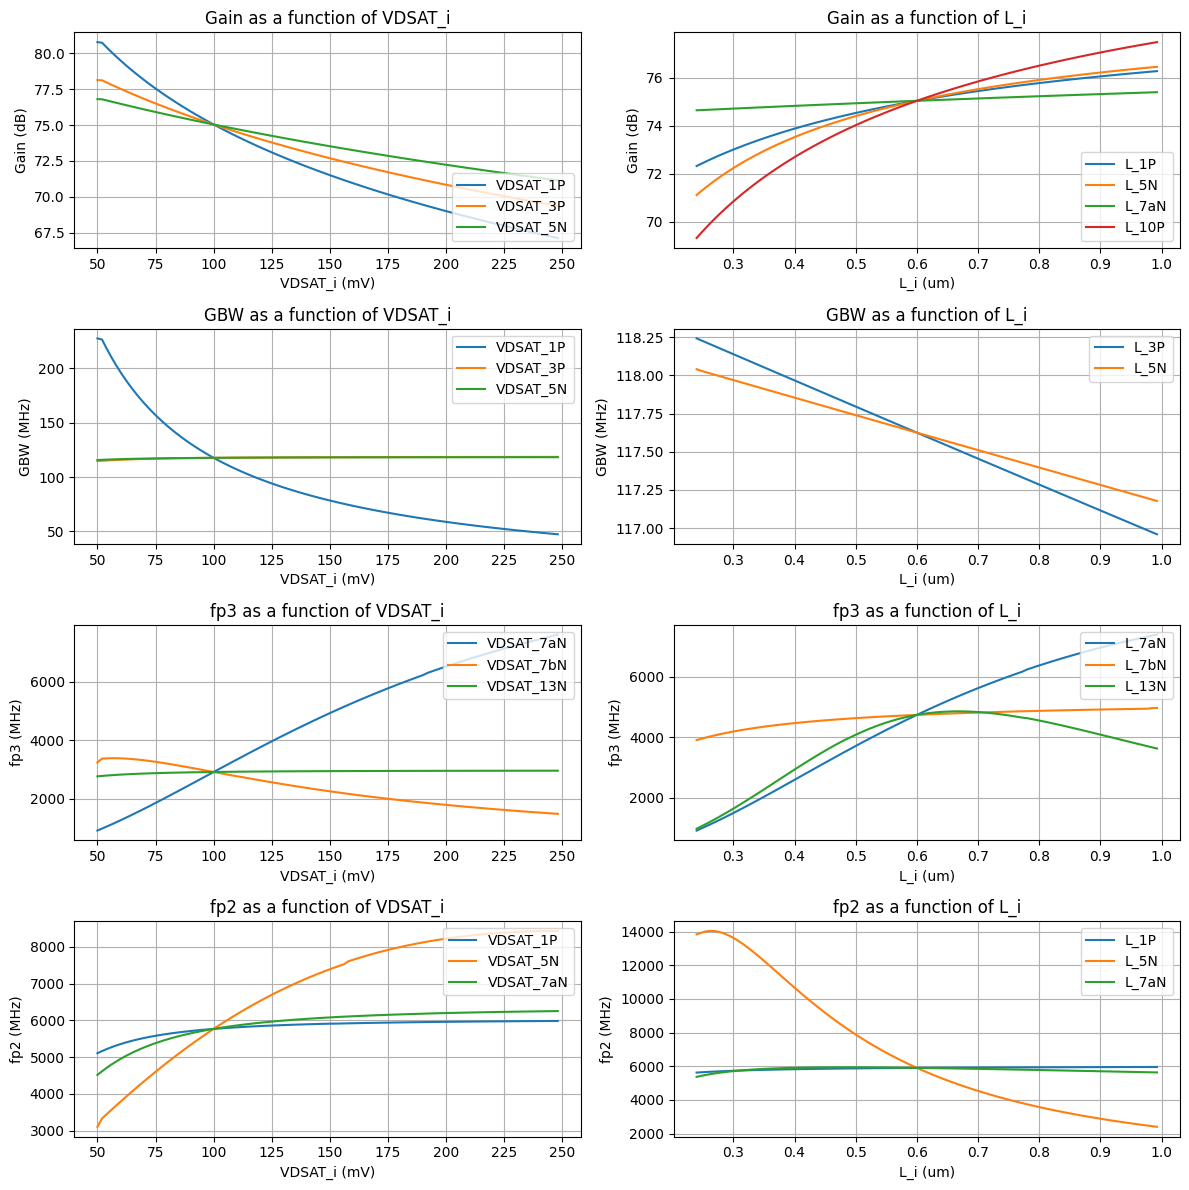

In [8]:
plt.figure(figsize=(12,12))

################################################## GAIN PLOTS ##################################################
plt.subplot(4, 2, 1);   plt.grid()
plt.plot(1e+03 * VSAT_arr, 20*np.log10(gain(IB, VSAT_arr, VDSAT_3P, VDSAT_5N,L_1P, L_5N, L_7aN, L_10P)))
plt.plot(1e+03 * VSAT_arr, 20*np.log10(gain(IB, VDSAT_1P, VSAT_arr, VDSAT_5N,L_1P, L_5N, L_7aN, L_10P)))
plt.plot(1e+03 * VSAT_arr, 20*np.log10(gain(IB, VDSAT_1P, VDSAT_3P, VSAT_arr,L_1P, L_5N, L_7aN, L_10P)))
plt.xlabel('VDSAT_i (mV)')
plt.ylabel('Gain (dB)')
plt.title('Gain as a function of VDSAT_i')
plt.legend(['VDSAT_1P','VDSAT_3P','VDSAT_5N'], loc="lower right")

plt.subplot (4, 2, 2); plt.grid ()
plt.plot (1e+06*L_arr, 20*np.log10(gain(IB, VDSAT_1P, VDSAT_3P, VDSAT_5N,L_arr, L_5N, L_7aN, L_10P)))
plt.plot (1e+06*L_arr, 20*np.log10(gain(IB, VDSAT_1P, VDSAT_3P, VDSAT_5N,L_1P, L_arr, L_7aN, L_10P)))
plt.plot (1e+06*L_arr, 20*np.log10(gain(IB, VDSAT_1P, VDSAT_3P, VDSAT_5N,L_1P, L_5N, L_arr, L_10P)))
plt.plot (1e+06*L_arr, 20*np.log10(gain(IB, VDSAT_1P, VDSAT_3P, VDSAT_5N,L_1P, L_5N, L_7aN, L_arr)))
plt.xlabel('L_i (um)')
plt.ylabel('Gain (dB)')
plt.title('Gain as a function of L_i')
plt.legend(['L_1P','L_5N','L_7aN', 'L_10P'], loc="lower right")

################################################## GBW PLOTS ##################################################
plt.subplot(4, 2, 3);   plt.grid()
plt.plot(1e+03 * VSAT_arr, 1e-06*GBW(IB, VSAT_arr, VDSAT_3P, VDSAT_5N, L_3P, L_5N, VDB_3P, VDB_5N, CL))
plt.plot(1e+03 * VSAT_arr, 1e-06*GBW(IB, VDSAT_1P, VSAT_arr, VDSAT_5N, L_3P, L_5N, VDB_3P, VDB_5N, CL))
plt.plot(1e+03 * VSAT_arr, 1e-06*GBW(IB, VDSAT_1P, VDSAT_3P, VSAT_arr, L_3P, L_5N, VDB_3P, VDB_5N, CL))
plt.xlabel('VDSAT_i (mV)')
plt.ylabel('GBW (MHz)')
plt.title('GBW as a function of VDSAT_i')
plt.legend(['VDSAT_1P','VDSAT_3P', 'VDSAT_5N'])

plt.subplot(4, 2, 4);   plt.grid()
plt.plot(1e+06 * L_arr, 1e-06*GBW(IB, VDSAT_1P, VDSAT_3P, VDSAT_5N, L_arr, L_5N, VDB_3P, VDB_5N, CL))
plt.plot(1e+06 * L_arr, 1e-06*GBW(IB, VDSAT_1P, VDSAT_3P, VDSAT_5N, L_3P, L_arr, VDB_3P, VDB_5N, CL))
plt.xlabel('L_i (um)')
plt.ylabel('GBW (MHz)')
plt.title('GBW as a function of L_i')
plt.legend(['L_3P','L_5N'], loc="upper right")


################################################## fp3 PLOTS ##################################################

plt.subplot(4, 2, 5);   plt.grid()
plt.plot(1e+03 * VSAT_arr, 1e-06* wp3(IB, VSAT_arr, VDSAT_7bN, VDSAT_13N, L_7aN, L_7bN, L_13N, VDB_13N)/2*np.pi)
plt.plot(1e+03 * VSAT_arr, 1e-06* wp3(IB, VDSAT_7aN, VSAT_arr, VDSAT_13N, L_7aN, L_7bN, L_13N, VDB_13N)/2*np.pi)
plt.plot(1e+03 * VSAT_arr, 1e-06* wp3(IB, VDSAT_7aN, VDSAT_7bN, VSAT_arr, L_7aN, L_7bN, L_13N, VDB_13N)/2*np.pi)
plt.xlabel('VDSAT_i (mV)')
plt.ylabel('fp3 (MHz)')
plt.title('fp3 as a function of VDSAT_i')
plt.legend(['VDSAT_7aN','VDSAT_7bN','VDSAT_13N'],  loc="upper right")

plt.subplot(4, 2, 6);   plt.grid()
plt.plot(1e+06 * L_arr, 1e-06* wp3(IB, VSAT_arr, VDSAT_7bN, VDSAT_13N, L_7aN, L_7bN, L_arr, VDB_13N)/2*np.pi)
plt.plot(1e+06 * L_arr, 1e-06* wp3(IB, VSAT_arr, VDSAT_7bN, VDSAT_13N, L_arr, L_7bN, L_13N, VDB_13N)/2*np.pi)
plt.plot(1e+06 * L_arr, 1e-06* wp3(IB, VSAT_arr, VDSAT_7bN, VDSAT_13N, L_7aN, L_arr, L_13N, VDB_13N)/2*np.pi)
plt.xlabel('L_i (um)')
plt.ylabel('fp3 (MHz)')
plt.title('fp3 as a function of L_i')
plt.legend(['L_7aN','L_7bN', 'L_13N'], loc="upper right")

################################################## fp2 PLOTS ##################################################

plt.subplot(4, 2, 7);   plt.grid()
plt.plot(1e+03 * VSAT_arr, 1e-06*wp2(IB, VSAT_arr, VDSAT_5N, VDSAT_7aN, L_1P, L_5N, L_7aN, VDB_1P, VDB_7aN, VBS_5N)/2*np.pi)
plt.plot(1e+03 * VSAT_arr, 1e-06*wp2(IB, VDSAT_1P, VSAT_arr, VDSAT_7aN, L_1P, L_5N, L_7aN, VDB_1P, VDB_7aN, VBS_5N)/2*np.pi)
plt.plot(1e+03 * VSAT_arr, 1e-06*wp2(IB, VDSAT_1P, VDSAT_5N, VSAT_arr, L_1P, L_5N, L_7aN, VDB_1P, VDB_7aN, VBS_5N)/2*np.pi)
plt.xlabel('VDSAT_i (mV)')
plt.ylabel('fp2 (MHz)')
plt.title('fp2 as a function of VDSAT_i')
plt.legend(['VDSAT_1P','VDSAT_5N', 'VDSAT_7aN'],  loc="upper right")

plt.subplot(4, 2, 8);   plt.grid()
plt.plot(1e+06 * L_arr, 1e-06*wp2(IB, VSAT_arr, VDSAT_5N, VDSAT_7aN, L_arr, L_5N, L_7aN, VDB_1P, VDB_7aN, VBS_5N)/2*np.pi)
plt.plot(1e+06 * L_arr, 1e-06*wp2(IB, VSAT_arr, VDSAT_5N, VDSAT_7aN, L_1P, L_arr, L_7aN, VDB_1P, VDB_7aN, VBS_5N)/2*np.pi)
plt.plot(1e+06 * L_arr, 1e-06*wp2(IB, VSAT_arr, VDSAT_5N, VDSAT_7aN, L_1P, L_5N, L_arr, VDB_1P, VDB_7aN, VBS_5N)/2*np.pi)
plt.xlabel('L_i (um)')
plt.ylabel('fp2 (MHz)')
plt.title('fp2 as a function of L_i')
plt.legend(['L_1P','L_5N','L_7aN'], loc="upper right")

plt.tight_layout()
plt.show()




# <u> Circuit optimization

In [9]:

IB  = 100e-06;   CL  = 2.0e-12;   VDD = 1.2;   BE  = 0.75

# Transistor lengths
L_1P     = 0.30e-06;  L_3P    = 0.6e-06;  L_5N     =   0.30e-06; L_7aN =   0.6e-06; L_7bN =   0.6e-06; L_9P =    0.6e-06; L_10P = 0.4e-06; L_13N = 0.6e-06;
# Saturation voltage voltage
VDSAT_1P = 100e-03;  VDSAT_3P = 120e-03;  VDSAT_5N = 110e-03;  VDSAT_7aN = 100e-03; VDSAT_7bN = 100e-03; VDSAT_9P = 100e-03; VDSAT_10P = 100e-03; VDSAT_13N = 100e-03;
print("Performance parameters:")

print("-> Gain = "+engFormat_Gain(20*np.log10(gain(IB, VDSAT_1P, VDSAT_3P, VDSAT_5N,L_1P, L_5N, L_7aN, L_10P))))
print("-> GBW  = "+engFormat_GBW(GBW(IB, VDSAT_1P, VDSAT_3P, VDSAT_5N, L_3P, L_5N, VDB_3P, VDB_5N,CL)))
print("-> OS   = "+engFormat_OS(OS(VDD, VDSAT_3P, VDSAT_5N,VDSAT_7aN, VDSAT_10P)))
print("-> PD   = "+engFormat_PD(PD(VDD, IB)))
print("-> FoM  = "+engFormat_FoM(FoM(GBW, CL, PD)))
print("-> fp3   = "+engFormat_GBW(wp3(IB, VDSAT_7aN, VDSAT_7bN, VDSAT_13N, L_7aN, L_7bN, L_13N, VDB_13N)/(np.pi*2)))
print("-> fp2   = "+engFormat_GBW(wp2(IB, VDSAT_1P, VDSAT_5N, VDSAT_7aN, L_1P, L_5N, L_7aN, VDB_1P, VDB_7aN, VBS_5N)/np.pi*2))
print(f"-> Excess noise = {Excess_Noise():.2f}")

print("\nDesign parameters:")

#perguntar se o par dde trasistors 1,2(a e b) sao do mesmo tamanho e de igual VDSAT
W_1P = W_P(0.25*IB, VDSAT_1P, L_1P); print("-> W_1P = "+engFormat_Width(W_1P));
W_3P = W_P(0.5*IB, VDSAT_3P, L_3P); print("-> W_3P = "+engFormat_Width(W_3P));
W_5N = W_N(0.5*IB, VDSAT_5N, L_5N); print("-> W_5N = "+engFormat_Width(W_5N));
W_7aN = W_N(0.75*IB, VDSAT_7aN, L_7aN); print("-> W_7aN = "+engFormat_Width(W_5N));
W_7bN = W_N(0.25*IB,VDSAT_7bN, L_7bN); print("-> W_7bN = "+engFormat_Width(W_7bN));
W_9P = W_P(   IB, VDSAT_9P, L_9P); print("-> W_9P = "+engFormat_Width(W_9P));
W_10P = W_P(0.5*IB, VDSAT_10P, L_10P); print("-> W_10P = "+engFormat_Width(W_10P));
W_13N = W_N( 0.25*IB, VDSAT_5N, L_5N); print("-> W_13P = "+engFormat_Width(W_10P));


print("\nDesign polarização")

W_B1P = W_P(0.1*IB, VDSAT_9P, L_9P);      print("-> W_B1P  = "+engFormat_Width(W_B1P))
W_B2P = W_B1P;
W_B3P = W_B1P;
##perguntar ao stor sobre os VDSATs
#quais sao os VDSATs e os L_s
W_B6P = W_P(0.2*IB, VDSAT_3P, L_3P);      print("-> W_B6P  = "+engFormat_Width(W_B6P))
W_B5N = W_N(0.2*IB, VDSAT_5N, L_5N);      print("-> W_B5N  = "+engFormat_Width(W_B5N))
##perguntar ao stor sobre VB3
## perguntar tanto a corrente como o VDSAT e L_min
W_B3N = W_N(0.1*IB, VDSAT_7bN, L_7bN);      print("-> W_B3N  = "+engFormat_Width(W_B3N))
W_B7N = W_B3N;

def area():
    return 2*(W_1P*L_1P)+ 2*(W_3P*L_3P)+ 2*(W_5N*L_5N) + (W_7aN*L_7aN) + (W_7bN*L_7bN) + 2*(W_9P*L_9P) +2*(W_10P*L_10P) + 2*(W_13N*L_13N)+ 3*(W_B1P*L_9P) + (W_B6P*L_3P) + (W_B5N*L_5N) + 2* (W_B3N*0.4* 0.6e-06)


print("\nArea:"+engFormat_Width(area()))

Performance parameters:
-> Gain = 66.970 dB
-> GBW  = 118.346 MHz
-> OS   = 690.000 mV
-> PD   = 288.000 µW
-> FoM  = 821.848 s/V^−2
-> fp3   = 295.296 MHz
-> fp2   = 6.970 GHz
-> Excess noise = 3.25

Design parameters:
-> W_1P = 10.65 µm
-> W_3P = 29.58 µm
-> W_5N = 10.12 µm
-> W_7aN = 10.12 µm
-> W_7bN = 12.25 µm
-> W_9P = 85.19 µm
-> W_10P = 28.40 µm
-> W_13P = 28.40 µm

Design polarização
-> W_B1P  = 8.69 µm
-> W_B6P  = 11.83 µm
-> W_B5N  = 4.02 µm
-> W_B3N  = 4.86 µm

Area:234.61 pm
